# LeNet-5

In [3]:
# 파이썬 2와 파이썬 3 지원
from __future__ import division, print_function, unicode_literals

# 공통
import numpy as np
import os

# 일관된 출력을 위해 유사난수 초기화
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# 맷플롯립 설정
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    
import tensorflow as tf
import numpy as np

/home/shin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 32*32*3) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 32*32*3) / 255.0
y_train = y_train.astype(np.int32).reshape(-1)
y_test = y_test.astype(np.int32).reshape(-1)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]
m,n = X_train.shape
print(y_train.shape)
print(X_train.shape)

(45000,)
(45000, 3072)


In [5]:
def fetch_batch(epoch, batch_index, batch_size):
    np.random.seed(epoch * n_batches + batch_index)  
    indices = np.random.randint(m, size=batch_size)
    X_batch = X_train[indices]
    y_batch = y_train[indices] 
    return X_batch, y_batch

# Leaky_Relu 사용하기

In [10]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01 * z, z, name=name)

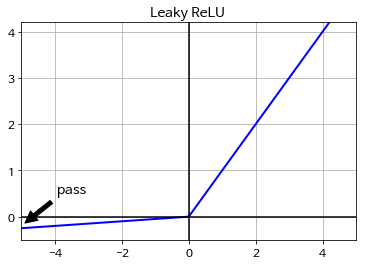

In [8]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('pass', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU ", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

죽는 Relu값의 그레디언트를 살리기 위한 방법 

# ELU 

In [17]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

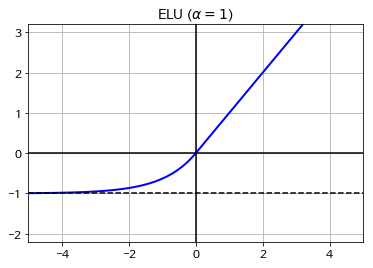

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

tf.nn.elu사용

# SELU

이 활성화 함수는 Günter Klambauer, Thomas Unterthiner, Andreas Mayr가 2017년에 쓴 [논문](https://arxiv.org/pdf/1706.02515.pdf)에서 소개되었습니다. 심층 신경망에서 다른 활성화 함수보다 뛰어난 성능을 내므로 꼭 이 함수를 시도해봐야 합니다.

In [29]:
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * elu(z, alpha)

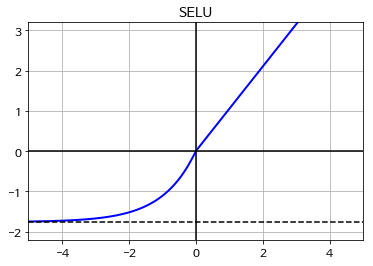

In [31]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

이 활성화 함수를 사용하면 100층으로 된 심층 신경망도 그래디언트 소실/폭주 문제없이 모든 층에서 대략 평균이 0이고 표준 편차가 1을 유지합니다:

tf.nn.selu 사용

In [32]:
import tensorflow as tf
import numpy as np

height = 32
width = 32
channels = 3
n_inputs = height * width * 3

conv1_fmaps = 5
conv1_ksize = 5
conv1_stride = 1
conv1_pad = "VALID"

pool2_fmap = conv1_fmaps

conv3_fmaps = 16
conv3_ksize = 5
conv3_stride = 1
conv3_pad = "VALID"

pool4_fmap = conv3_fmaps

conv5_fmaps = 32
conv5_ksize = 5
conv5_stride = 1
conv5_pad = "VALID"


n_fc1 = 84
n_outputs = 10

reset_graph()

with tf.name_scope("inputs"):
    X = tf.placeholder(tf.float32, shape=[None, n_inputs], name="X")
    X_reshaped = tf.reshape(X, shape=[-1, height, width, channels])
    y = tf.placeholder(tf.int32, shape=[None], name="y")

with tf.name_scope("conv1"):
    conv1 = tf.layers.conv2d(X_reshaped, filters=conv1_fmaps, kernel_size=conv1_ksize,
                         strides=conv1_stride, padding=conv1_pad,
                         activation=tf.nn.selu, name="conv1")

with tf.name_scope("pool2"):
    pool2 = tf.nn.max_pool(conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="VALID")

with tf.name_scope("conv3"):
    conv3 = tf.layers.conv2d(pool2, filters=conv3_fmaps, kernel_size=conv3_ksize,
                         strides=conv3_stride, padding=conv3_pad,
                         activation=tf.nn.selu, name="conv3")

with tf.name_scope("pool4"):
    pool4 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
    
with tf.name_scope("conv5"):
    conv5 = tf.layers.conv2d(pool4, filters=conv5_fmaps, kernel_size=conv5_ksize,
                            strides=conv5_stride, padding=conv5_pad,
                            activation=tf.nn.selu, name="conv5")
with tf.name_scope("pool_flat"):
    pool_flat = tf.reshape(conv5, shape=[-1, conv5_fmaps*1])

with tf.name_scope("fc1"):
    fc1 = tf.layers.dense(pool_flat, n_fc1, activation=tf.nn.selu, name="fc1")

with tf.name_scope("output"):
    logits = tf.layers.dense(fc1, n_outputs, name="output")
    Y_proba = tf.nn.softmax(logits, name="Y_proba")

with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [34]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [35]:
mse_summary = tf.summary.scalar('accuracy', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [36]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [37]:
n_epochs = 50
batch_size = 100
n_batches = int(np.ceil(m / batch_size))

with tf.Session(config=config) as sess:
    init.run()
    for epoch in range(n_epochs):
#         for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
#             sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        for batch_index in range(n_batches):
            X_batch, y_batch = fetch_batch(epoch, batch_index, batch_size)
            if batch_index % 10 == 0:
                summary_str = mse_summary.eval(feed_dict={X: X_batch, y: y_batch})
                step = epoch * n_batches + batch_index
                file_writer.add_summary(summary_str, step)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        acc_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "배치 데이터 정확도:", acc_batch, "검증 세트 정확도:", acc_val)

    acc_test = accuracy.eval(feed_dict={X: X_test,
                                        y: y_test})
    print("테스트 세트에서 최종 정확도:", acc_test)
        
    save_path = saver.save(sess, "./my_mnist_model")
    
    file_writer.close()

0 배치 데이터 정확도: 0.53 검증 세트 정확도: 0.4896
1 배치 데이터 정확도: 0.6 검증 세트 정확도: 0.5204
2 배치 데이터 정확도: 0.57 검증 세트 정확도: 0.5404
3 배치 데이터 정확도: 0.58 검증 세트 정확도: 0.553
4 배치 데이터 정확도: 0.55 검증 세트 정확도: 0.5704
5 배치 데이터 정확도: 0.59 검증 세트 정확도: 0.5698
6 배치 데이터 정확도: 0.58 검증 세트 정확도: 0.572
7 배치 데이터 정확도: 0.64 검증 세트 정확도: 0.5868
8 배치 데이터 정확도: 0.56 검증 세트 정확도: 0.588
9 배치 데이터 정확도: 0.59 검증 세트 정확도: 0.59
10 배치 데이터 정확도: 0.63 검증 세트 정확도: 0.59
11 배치 데이터 정확도: 0.7 검증 세트 정확도: 0.5954
12 배치 데이터 정확도: 0.6 검증 세트 정확도: 0.602
13 배치 데이터 정확도: 0.56 검증 세트 정확도: 0.6012
14 배치 데이터 정확도: 0.65 검증 세트 정확도: 0.6
15 배치 데이터 정확도: 0.7 검증 세트 정확도: 0.5976
16 배치 데이터 정확도: 0.63 검증 세트 정확도: 0.6154
17 배치 데이터 정확도: 0.68 검증 세트 정확도: 0.6166
18 배치 데이터 정확도: 0.68 검증 세트 정확도: 0.607
19 배치 데이터 정확도: 0.71 검증 세트 정확도: 0.615
20 배치 데이터 정확도: 0.72 검증 세트 정확도: 0.6182
21 배치 데이터 정확도: 0.72 검증 세트 정확도: 0.6212
22 배치 데이터 정확도: 0.69 검증 세트 정확도: 0.6196
23 배치 데이터 정확도: 0.68 검증 세트 정확도: 0.6216
24 배치 데이터 정확도: 0.69 검증 세트 정확도: 0.6172
25 배치 데이터 정확도: 0.73 검증 세트 정확도: 0.6206
26 배치 데이터 정확도: 0.7 검증 세트 정확도: 0.6178
27

결과

- LeakyReLU 보다는 ELU 